In [2]:
# Setup Environment
import time
from optuna.importance import MeanDecreaseImpurityImportanceEvaluator
import os
import logging
import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten
import joblib # Used for encoding horse_id
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import optuna
import optuna.visualization as viz
from catboost import CatBoostRanker, CatBoostRegressor, CatBoostClassifier, Pool
import numpy as np
import itertools
import pyspark.sql.functions as F
from pyspark.sql.functions import (col, count, row_number, abs, unix_timestamp, mean, 
                                   when, lit, min as F_min, max as F_max , upper, trim,
                                   row_number, mean as F_mean, countDistinct, last, first, when)
from src.data_preprocessing.data_prep1.data_utils import initialize_environment 
# Set global references to None
spark = None
master_results_df = None
race_df = None
df = None
training_data = None
train_df = None

In [4]:
spark, jdbc_url, jdbc_properties, parquet_dir, log_file = initialize_environment()

Spark session created successfully.


In [106]:
train_df = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/train_df")
global_speed_score = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/global_speed_score.parquet")


In [107]:
global_speed_score.printSchema()

root
 |-- horse_id: double (nullable = true)
 |-- race_class_id: string (nullable = true)
 |-- group_id: string (nullable = true)
 |-- class_rating: double (nullable = true)
 |-- course_cd: string (nullable = true)
 |-- race_date: date (nullable = true)
 |-- race_number: double (nullable = true)
 |-- axciskey: string (nullable = true)
 |-- post_time: timestamp (nullable = true)
 |-- saddle_cloth_number: string (nullable = true)
 |-- horse_name: string (nullable = true)
 |-- official_fin: integer (nullable = true)
 |-- time_behind: double (nullable = true)
 |-- pace_delta_time: double (nullable = true)
 |-- running_time: double (nullable = true)
 |-- dist_bk_gate4: double (nullable = true)
 |-- total_distance_ran: double (nullable = true)
 |-- speed_rating: double (nullable = true)
 |-- prev_speed_rating: double (nullable = true)
 |-- previous_class: double (nullable = true)
 |-- purse: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- date_of_birth: date (nullable = t

In [108]:
# Show basic descriptive stats for global_speed_score
global_speed_score_stats = global_speed_score.select("global_speed_score_iq").describe()
global_speed_score_stats.show()

+-------+---------------------+
|summary|global_speed_score_iq|
+-------+---------------------+
|  count|               776892|
|   mean|             Infinity|
| stddev|                  NaN|
|    min|   -95.69137003907414|
|    max|             Infinity|
+-------+---------------------+



In [109]:
global_speed_score_quantiles = global_speed_score.select("global_speed_score_iq").summary()
global_speed_score_quantiles.show()

+-------+---------------------+
|summary|global_speed_score_iq|
+-------+---------------------+
|  count|               776892|
|   mean|             Infinity|
| stddev|                  NaN|
|    min|   -95.69137003907414|
|    25%|    96.15593688162593|
|    50%|    99.58951648694516|
|    75%|   104.65383164797748|
|    max|             Infinity|
+-------+---------------------+



In [97]:
# Show count, mean, stddev, min, 25%, 50%, 75%, and max
global_speed_score_quantiles = global_speed_score.select("horse_avg_speed_agg").summary()
global_speed_score_quantiles.show()

+-------+-------------------+
|summary|horse_avg_speed_agg|
+-------+-------------------+
|  count|             778310|
|   mean|  95.13276583922628|
| stddev| 16.528848573004836|
|    min|  40.00000000000377|
|    25%|   83.0603724952937|
|    50%|  95.66839128375153|
|    75%| 107.54774770594473|
|    max|              150.0|
+-------+-------------------+



In [110]:
import pyspark.sql.functions as F

df_bins = (
    global_speed_score.withColumn("score_bin", F.floor(F.col("global_speed_score_iq") / 10) * 10)
      .groupBy("score_bin")
      .count()
      .orderBy("score_bin")
)

df_bins.show(100, truncate=False)

+---------+------+
|score_bin|count |
+---------+------+
|null     |1418  |
|-100     |1     |
|-10      |12    |
|0        |1     |
|10       |4     |
|20       |11    |
|30       |27    |
|40       |113   |
|50       |401   |
|60       |1863  |
|70       |8789  |
|80       |36983 |
|90       |366393|
|100      |306368|
|110      |51326 |
|120      |3503  |
|130      |172   |
|140      |617   |
|150      |137   |
|160      |37    |
|170      |88    |
|180      |19    |
|190      |2     |
|200      |20    |
|210      |1     |
|220      |4     |
+---------+------+



In [100]:
# Example for standardized_score with bin size = 0.5
df_bins_std = (
    global_speed_score.withColumn("score_bin", F.floor(F.col("standardized_score") / 0.5) * 0.5)
      .groupBy("score_bin")
      .count()
      .orderBy("score_bin")
)
df_bins_std.show(100, truncate=False)

+---------+------+
|score_bin|count |
+---------+------+
|null     |1418  |
|-89.0    |1     |
|-25.5    |1     |
|-22.0    |1     |
|-19.0    |3     |
|-18.0    |1     |
|-17.0    |2     |
|-16.0    |1     |
|-15.5    |1     |
|-15.0    |2     |
|-14.5    |3     |
|-14.0    |2     |
|-13.5    |2     |
|-13.0    |2     |
|-12.5    |5     |
|-12.0    |5     |
|-11.5    |7     |
|-11.0    |2     |
|-10.5    |9     |
|-10.0    |5     |
|-9.5     |21    |
|-9.0     |24    |
|-8.5     |37    |
|-8.0     |40    |
|-7.5     |57    |
|-7.0     |79    |
|-6.5     |112   |
|-6.0     |153   |
|-5.5     |280   |
|-5.0     |398   |
|-4.5     |687   |
|-4.0     |1168  |
|-3.5     |2040  |
|-3.0     |3745  |
|-2.5     |7077  |
|-2.0     |13510 |
|-1.5     |23184 |
|-1.0     |101243|
|-0.5     |260677|
|0.0      |169489|
|0.5      |127447|
|1.0      |41611 |
|1.5      |15613 |
|2.0      |4805  |
|2.5      |1714  |
|3.0      |444   |
|3.5      |124   |
|4.0      |50    |
|4.5      |47    |
|5.0      |2

In [111]:
import matplotlib.pyplot as plt

# Convert the column to an RDD and use the histogram function
hist_result = (
    global_speed_score.select("global_speed_score_iq")
      .rdd
      .flatMap(lambda x: x)  # flatten out the column values
      .histogram(10)         # 10 bins by default
)

# hist_result returns a tuple (bins, counts)
# bins: list of bin boundaries
# counts: list of counts in each bin

bins = hist_result[0]
counts = hist_result[1]

plt.figure(figsize=(8, 5))
plt.bar(x=bins[:-1], height=counts, width=(bins[1] - bins[0]) * 0.9)
plt.xlabel("global_speed_score")
plt.ylabel("Count")
plt.title("Histogram of global_speed_score")
plt.show()

ValueError: Can not generate buckets with infinite value

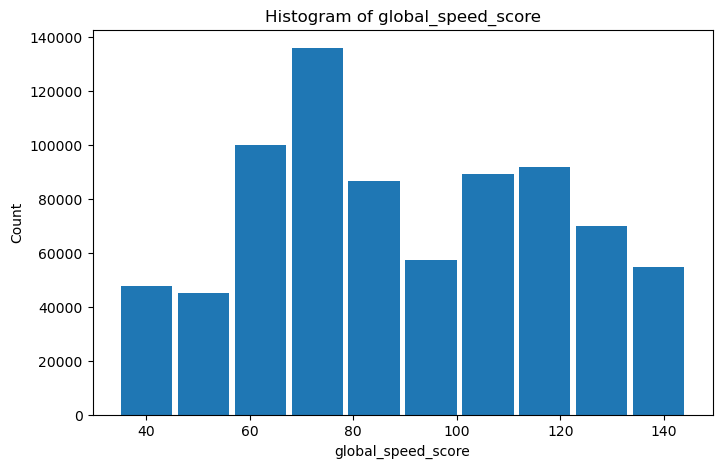

In [103]:
import matplotlib.pyplot as plt

# Convert the column to an RDD and use the histogram function
hist_result = (
    global_speed_score.select("global_speed_score")
      .rdd
      .flatMap(lambda x: x)  # flatten out the column values
      .histogram(10)         # 10 bins by default
)

# hist_result returns a tuple (bins, counts)
# bins: list of bin boundaries
# counts: list of counts in each bin

bins = hist_result[0]
counts = hist_result[1]

plt.figure(figsize=(8, 5))
plt.bar(x=bins[:-1], height=counts, width=(bins[1] - bins[0]) * 0.9)
plt.xlabel("global_speed_score")
plt.ylabel("Count")
plt.title("Histogram of global_speed_score")
plt.show()

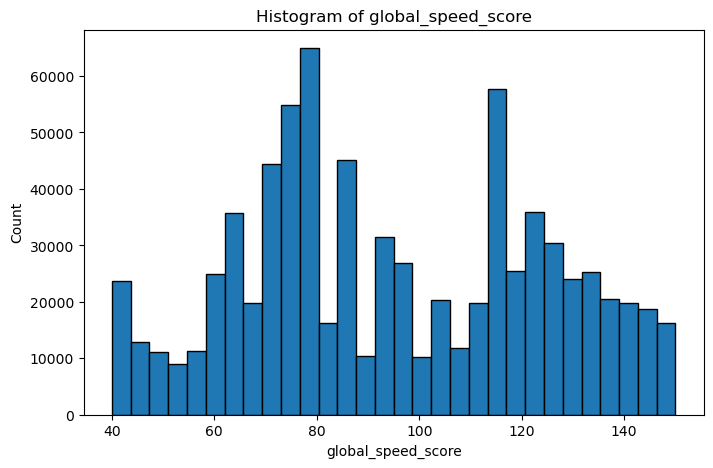

In [104]:
pdf = global_speed_score.select("global_speed_score").toPandas()

plt.figure(figsize=(8, 5))
plt.hist(pdf["global_speed_score"], bins=30, edgecolor='black')
plt.xlabel("global_speed_score")
plt.ylabel("Count")
plt.title("Histogram of global_speed_score")
plt.show()

In [56]:
# Count number of races
# Count the number of unique races
race_count = (
    global_speed_score
    .select("course_cd", "race_date", "race_number")
    .distinct()  # Get unique race combinations
    .count()
)

# Print the number of unique races
print(f"Total number of races: {race_count}")

Total number of races: 105231


In [51]:
from pyspark.sql import functions as F

# Check if the column exists, and drop it if it does
if "horse_count" in global_speed_score.columns:
    global_speed_score = global_speed_score.drop("horse_count")

In [57]:
# Count the number of horses in each race
race_horse_counts = (
    global_speed_score
    .groupBy("course_cd", "race_date", "race_number")
    .agg(F.count("saddle_cloth_number").alias("horse_count"))  # Count horses per race
)

# Join the count back to the main DataFrame
global_speed_score = global_speed_score.join(race_horse_counts, on=["course_cd", "race_date", "race_number"], how="left")

In [58]:
# Define the race to filter (modify these values as needed)
selected_course = "TOP"
selected_date = "2025-03-01"  # Adjust as needed
selected_race = 2  # Adjust as needed

# Filter and sort the DataFrame
filtered_race = (
    global_speed_score
    .filter(
        (F.col("course_cd") == selected_course) &
        (F.col("race_date") == selected_date) &
        (F.col("race_number") == selected_race)
    )
    .select(
        "course_cd", 
        "race_date", 
        "race_number", 
        "horse_name", 
        "saddle_cloth_number", 
        "horse_count"
    )
    .orderBy(F.col("saddle_cloth_number").asc())  # Sort by saddle_cloth_number
)

# Show the filtered race details
filtered_race.show(truncate=False)

+---------+----------+-----------+-----------------+-------------------+-----------+
|course_cd|race_date |race_number|horse_name       |saddle_cloth_number|horse_count|
+---------+----------+-----------+-----------------+-------------------+-----------+
|TOP      |2025-03-01|2.0        |Rerun            |1                  |14         |
|TOP      |2025-03-01|2.0        |FIVE POCKETS     |10                 |14         |
|TOP      |2025-03-01|2.0        |Willie Cat       |11                 |14         |
|TOP      |2025-03-01|2.0        |Stillbilly       |12                 |14         |
|TOP      |2025-03-01|2.0        |Get Away With It |13                 |14         |
|TOP      |2025-03-01|2.0        |Denali Lightning |14                 |14         |
|TOP      |2025-03-01|2.0        |Gentle Ben       |2                  |14         |
|TOP      |2025-03-01|2.0        |ARKY ROAD        |3                  |14         |
|TOP      |2025-03-01|2.0        |Mo Heartaches    |4            

In [32]:
# Filter the DataFrame for the specific race.
race_df = speed_score.filter(
    (F.col("course_cd") == "TGP") &
    (F.col("race_date") == F.lit("2025-02-23").cast("date")) &
    (F.col("race_number") == 2)
)

# Select and order the columns of interest.
race_df.select("saddle_cloth_number", "horse_name", "course_cd", "race_date", "race_number") \
       .orderBy("saddle_cloth_number") \
       .show(truncate=False)

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `horse_count` cannot be resolved. Did you mean one of the following? [`race_count`, `horse_id`, `horse_name`, `course_cd`, `trk_cond`].;
'Project [saddle_cloth_number#3069, horse_name#3070, course_cd#3064, race_date#3065, race_number#3066, 'horse_count]
+- Filter (((course_cd#3064 = TGP) AND (race_date#3065 = cast(2025-02-23 as date))) AND (race_number#3066 = cast(2 as double)))
   +- Relation [course_cd#3064,race_date#3065,race_number#3066,horse_id#3067,axciskey#3068,saddle_cloth_number#3069,horse_name#3070,official_fin#3071,time_behind#3072,pace_delta_time#3073,running_time#3074,dist_bk_gate4#3075,total_distance_ran#3076,speed_rating#3077,prev_speed_rating#3078,previous_class#3079,purse#3080,weight#3081,date_of_birth#3082,sex#3083,equip#3084,claimprice#3085,surface#3086,distance_meters#3087,class_rating#3088,previous_distance#3089,previous_surface#3090,off_finish_last_race#3091,power#3092,trk_cond#3093,med#3094,morn_odds#3095,avgspd#3096,starts#3097,race_type#3098,net_sentiment#3099,stk_clm_md#3100,turf_mud_mark#3101,avg_spd_sd#3102,ave_cl_sd#3103,hi_spd_sd#3104,pstyerl#3105,all_starts#3106,all_win#3107,all_place#3108,all_show#3109,all_fourth#3110,all_earnings#3111,horse_itm_percentage#3112,cond_starts#3113,cond_win#3114,cond_place#3115,cond_show#3116,cond_fourth#3117,cond_earnings#3118,jock_win_percent#3119,jock_itm_percent#3120,trainer_win_percent#3121,trainer_itm_percent#3122,jt_win_percent#3123,jt_itm_percent#3124,jock_win_track#3125,jock_itm_track#3126,trainer_win_track#3127,trainer_itm_track#3128,jt_win_track#3129,jt_itm_track#3130,sire_itm_percentage#3131,sire_roi#3132,dam_itm_percentage#3133,dam_roi#3134,total_races_5#3135,avg_fin_5#3136,avg_speed_5#3137,best_speed#3138,avg_beaten_len_5#3139,first_race_date_5#3140,most_recent_race_5#3141,avg_dist_bk_gate1_5#3142,avg_dist_bk_gate2_5#3143,avg_dist_bk_gate3_5#3144,avg_dist_bk_gate4_5#3145,avg_speed_fullrace_5#3146,avg_stride_length_5#3147,avg_strfreq_q1_5#3148,avg_strfreq_q2_5#3149,avg_strfreq_q3_5#3150,avg_strfreq_q4_5#3151,prev_speed#3152,speed_improvement#3153,prev_race_date#3154,days_off#3155,layoff_cat#3156,avg_workout_rank_3#3157,count_workouts_3#3158,race_count#3159,track_name#3160,has_gps#3161,data_flag#3162,missing_gps_flag#3163,gps_present#3164,age_at_race_day#3165,race_missing_flag#3166,class_multiplier#3167,class_offset#3168,official_distance#3169,base_speed#3170,wide_factor#3171,par_time#3172,par_diff_ratio#3173,raw_performance_score#3174,dist_penalty#3175,standardized_score#3176,normalized_score#3177,median_normalized#3178,global_speed_score#3179,race_date_str#3180,group_id#3181] parquet


In [10]:
horse_embedding.printSchema()

root
 |-- course_cd: string (nullable = true)
 |-- race_date: date (nullable = true)
 |-- race_number: double (nullable = true)
 |-- horse_id: double (nullable = true)
 |-- axciskey: string (nullable = true)
 |-- saddle_cloth_number: string (nullable = true)
 |-- horse_name: string (nullable = true)
 |-- official_fin: long (nullable = true)
 |-- time_behind: double (nullable = true)
 |-- pace_delta_time: double (nullable = true)
 |-- running_time: double (nullable = true)
 |-- dist_bk_gate4: double (nullable = true)
 |-- total_distance_ran: double (nullable = true)
 |-- speed_rating: double (nullable = true)
 |-- prev_speed_rating: double (nullable = true)
 |-- previous_class: double (nullable = true)
 |-- purse: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- date_of_birth: date (nullable = true)
 |-- sex: string (nullable = true)
 |-- equip: string (nullable = true)
 |-- claimprice: double (nullable = true)
 |-- surface: string (nullable = true)
 |-- distance_mete

In [13]:
from pyspark.sql import functions as F
from pyspark.sql import Window

# Define the list of TPD tracks you want to filter for
tpd_tracks = [
    'CNL', 'SAR', 'PIM', 'TSA', 'BEL', 'MVR', 'TWO', 'CLS', 'KEE', 'TAM', 'TTP', 'TKD', 
    'ELP', 'PEN', 'HOU', 'DMR', 'TLS', 'AQU', 'MTH', 'TGP', 'TGG', 'CBY', 'LRL', 
    'TED', 'IND', 'CTD', 'ASD', 'TCD', 'LAD', 'TOP'
]

# Convert saddle_cloth_number to Integer (if stored as string)
horse_embedding = horse_embedding.withColumn(
    "saddle_cloth_number", F.col("saddle_cloth_number").cast("int")
)

# Define window partitioned by race and ordered by saddle_cloth_number
race_window = Window.partitionBy("course_cd", "race_date", "race_number").orderBy("saddle_cloth_number")

# Add a column for expected saddle_cloth_number (incremental index starting at 1)
horse_embedding = horse_embedding.withColumn(
    "expected_number",
    F.row_number().over(race_window)
)

# Identify races where saddle_cloth_number != expected_number
races_with_gaps = (
    horse_embedding
    .filter(F.col("saddle_cloth_number") != F.col("expected_number"))
    .filter(F.col("course_cd").isin(tpd_tracks))  # <-- Track filter applied here
    .select("course_cd", "race_date", "race_number")
    .distinct()
)

# Show races with non-contiguous saddle cloth numbers from the specified tracks
races_with_gaps.show()

+---------+----------+-----------+
|course_cd| race_date|race_number|
+---------+----------+-----------+
|      AQU|2022-04-15|        2.0|
|      AQU|2022-11-17|        2.0|
|      AQU|2023-04-08|        8.0|
|      AQU|2023-04-14|        3.0|
|      AQU|2023-04-23|        8.0|
|      AQU|2023-11-12|        7.0|
|      AQU|2023-12-17|        5.0|
|      AQU|2024-02-11|        3.0|
|      AQU|2025-01-02|        5.0|
|      AQU|2025-01-04|        6.0|
|      AQU|2025-01-11|        5.0|
|      AQU|2025-01-12|        6.0|
|      CBY|2022-09-15|       11.0|
|      CBY|2023-08-03|        4.0|
|      CBY|2024-06-01|        4.0|
|      CBY|2024-07-04|        1.0|
|      CBY|2024-07-06|        6.0|
|      CBY|2024-07-13|        7.0|
|      CNL|2022-08-23|        8.0|
|      CNL|2023-09-08|       10.0|
+---------+----------+-----------+
only showing top 20 rows



In [14]:
from pyspark.sql import functions as F
from pyspark.sql import Window

# Define the specific track(s) you want to filter for
selected_tracks = ['TOP']  # Change this to filter for different tracks

# Convert saddle_cloth_number to Integer (if stored as string)
horse_embedding = horse_embedding.withColumn(
    "saddle_cloth_number", F.col("saddle_cloth_number").cast("int")
)

# Define window partitioned by race and ordered by saddle_cloth_number
race_window = Window.partitionBy("course_cd", "race_date", "race_number").orderBy("saddle_cloth_number")

# Add a column for expected saddle_cloth_number (incremental index starting at 1)
horse_embedding = horse_embedding.withColumn(
    "expected_number",
    F.row_number().over(race_window)
)

# Identify races where saddle_cloth_number != expected_number
races_with_gaps = (
    horse_embedding
    .filter(F.col("saddle_cloth_number") != F.col("expected_number"))
    .filter(F.col("course_cd").isin(selected_tracks))  # <-- Filter for specific track(s)
    .select("course_cd", "race_date", "race_number")
    .distinct()
)

# Show races with non-contiguous saddle cloth numbers for the selected track(s)
races_with_gaps.show()

+---------+----------+-----------+
|course_cd| race_date|race_number|
+---------+----------+-----------+
|      TOP|2022-03-25|        8.0|
|      TOP|2022-05-01|        1.0|
|      TOP|2023-12-29|        1.0|
|      TOP|2024-02-03|       11.0|
|      TOP|2024-03-08|        9.0|
|      TOP|2023-02-20|        6.0|
|      TOP|2023-04-28|        7.0|
|      TOP|2025-01-04|        5.0|
|      TOP|2022-03-05|       10.0|
|      TOP|2023-01-20|        5.0|
|      TOP|2023-03-09|        6.0|
|      TOP|2023-03-18|        9.0|
|      TOP|2024-04-20|        9.0|
|      TOP|2022-04-01|        3.0|
|      TOP|2023-02-05|        1.0|
|      TOP|2024-03-07|        3.0|
|      TOP|2023-01-01|        7.0|
|      TOP|2023-01-21|       10.0|
|      TOP|2023-03-04|        3.0|
|      TOP|2024-03-24|        4.0|
+---------+----------+-----------+
only showing top 20 rows



Approach

>1.	Find races where saddle cloth numbers are non-contiguous (already identified in races_with_gaps).

>2.	Use that list to filter the main dataset (horse_embedding) and retrieve the horses that are present in those races.

In [15]:
from pyspark.sql import functions as F
from pyspark.sql import Window

# Convert saddle_cloth_number to Integer (if stored as string)
horse_embedding = horse_embedding.withColumn(
    "saddle_cloth_number", F.col("saddle_cloth_number").cast("int")
)

# Define window partitioned by race and ordered by saddle_cloth_number
race_window = Window.partitionBy("course_cd", "race_date", "race_number").orderBy("saddle_cloth_number")

# Add a column for expected saddle_cloth_number (incremental index starting at 1)
horse_embedding = horse_embedding.withColumn(
    "expected_number",
    F.row_number().over(race_window)
)

# Identify races where saddle_cloth_number != expected_number
races_with_gaps = (
    horse_embedding
    .filter(F.col("saddle_cloth_number") != F.col("expected_number"))
    .select("course_cd", "race_date", "race_number")
    .distinct()
)

# Now, retrieve all horses in these races so we can see what saddle cloth numbers are present
horses_in_missing_races = (
    horse_embedding
    .join(races_with_gaps, ["course_cd", "race_date", "race_number"])  # Join to get only races with gaps
    .select("course_cd", "race_date", "race_number", "horse_name", "saddle_cloth_number")
    .orderBy("course_cd", "race_date", "race_number", "saddle_cloth_number")  # Order for readability
)

# Show results
horses_in_missing_races.show(50, truncate=False)

+---------+----------+-----------+---------------------+-------------------+
|course_cd|race_date |race_number|horse_name           |saddle_cloth_number|
+---------+----------+-----------+---------------------+-------------------+
|ALB      |2022-07-30|1.0        |Indianofgold         |1                  |
|ALB      |2022-07-30|1.0        |Nacho Grande         |2                  |
|ALB      |2022-07-30|1.0        |Tatas Joe Mark       |4                  |
|ALB      |2022-07-30|1.0        |Gone Prospecting     |5                  |
|ALB      |2022-07-30|1.0        |Beach Runner         |6                  |
|ALB      |2022-07-30|1.0        |Clue                 |7                  |
|ALB      |2022-07-30|1.0        |M G Lookingood       |8                  |
|ALB      |2022-07-30|1.0        |Diabolical Fire      |9                  |
|ALB      |2022-07-30|1.0        |Arbitro              |10                 |
|ALB      |2022-07-30|4.0        |Hematite             |1                  |

In [23]:
# Filter the DataFrame for the specific race.
race_df = horse_enhanced.filter(
    (F.col("course_cd") == "AQU") &
    (F.col("race_date") == F.lit("2025-02-23").cast("date")) &
    (F.col("race_number") == 10)
)

# Select and order the columns of interest.
race_df.select("saddle_cloth_number", "horse_name", "course_cd", "race_date", "race_number") \
       .orderBy("saddle_cloth_number") \
       .show(truncate=False)

+-------------------+-----------------+---------+----------+-----------+
|saddle_cloth_number|horse_name       |course_cd|race_date |race_number|
+-------------------+-----------------+---------+----------+-----------+
|1                  |Katerina Ristova |AQU      |2025-02-23|10.0       |
|2                  |Rasta Girl       |AQU      |2025-02-23|10.0       |
|4                  |Melancia         |AQU      |2025-02-23|10.0       |
|5                  |Grand Crossing   |AQU      |2025-02-23|10.0       |
|8                  |Game Like Reyana |AQU      |2025-02-23|10.0       |
|9                  |Improbable Friend|AQU      |2025-02-23|10.0       |
+-------------------+-----------------+---------+----------+-----------+

